# Mixture Models

See:
* https://stephens999.github.io/fiveMinuteStats/intro_to_mixture_models.html
* https://en.wikipedia.org/wiki/Mixture_model
* http://statweb.stanford.edu/~tibs/stat315a/LECTURES/em.pdf

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Summary

Sometimes we come across weird distributions, for example,

![](weird_dist.png)

and we might wonder - how on earth are we meant to summarise this? This doesn't look like any distribution I know of. However, many things in the world are not due to a single distribution but the sum of many! For example:
* Prices of books - paperback fiction, hardback fiction, paperback non-fiction, hardback non-fiction, textbooks, etc.
* Intrinsic brighness of astronomical objects - stars, galaxies, quasars, etc

In these cases it can be much easier to build an overall distribution as a sum of these simpler components. The weird distribution above is actually just the distribution of adult heights - a combination of two equally weighted normal distributions representing men and women. When we split out these components this becomes obvious.

![](obvious_dist.png)

## Generate the weird distribution

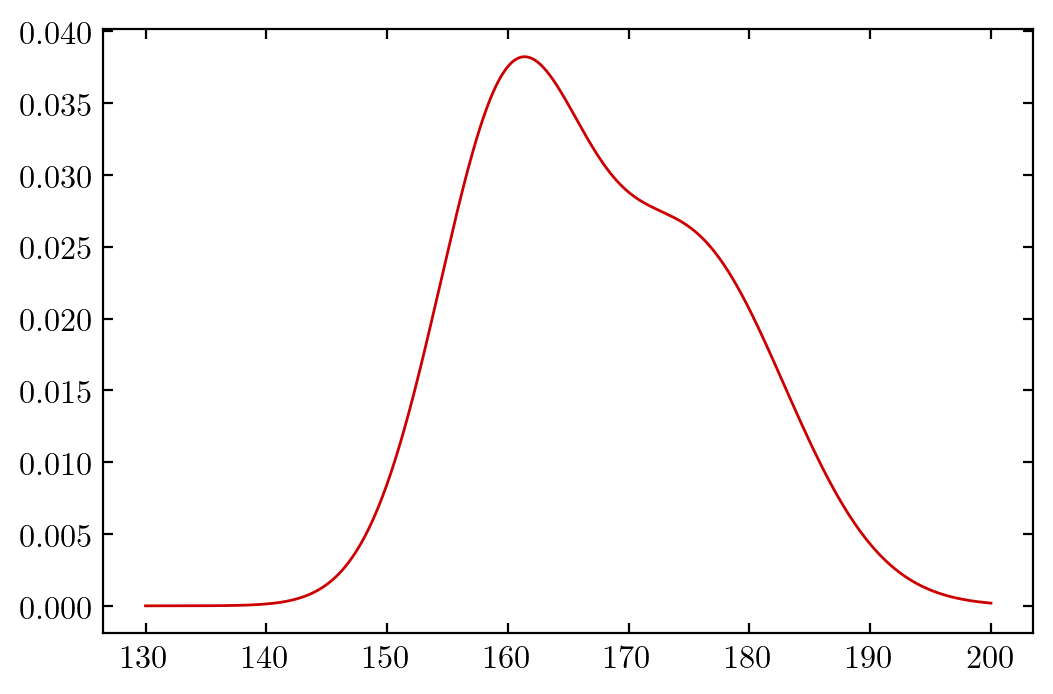

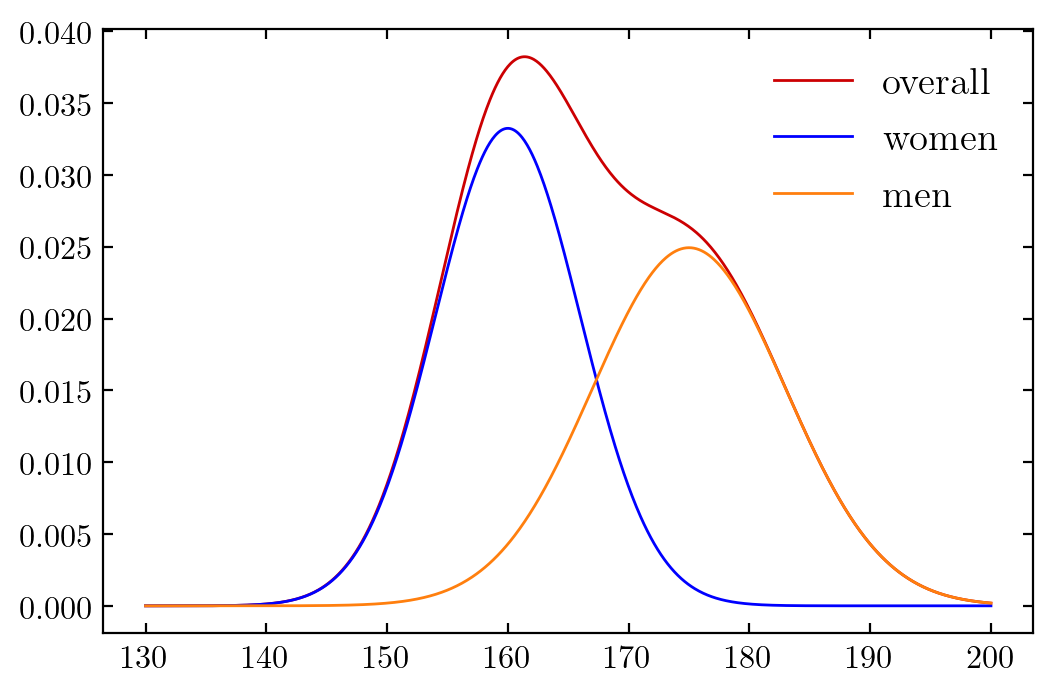

In [26]:
means = np.array([160, 175])
variances = np.array([6, 8])
fractions = np.array([0.5, 0.5])

locs = np.linspace(130, 200, num=1000)
values = []
for i in range(len(means)):
    values.append(scipy.stats.norm(means[i], variances[i]).pdf(locs) * fractions[i])
    
fig, ax = plt.subplots()
ax.plot(locs, np.sum(values, axis=0))
fig.savefig("./weird_dist.png", dpi=100)

fig, ax = plt.subplots()
ax.plot(locs, np.sum(values, axis=0), label="overall")
for i, label in enumerate(["women", "men"]):
    ax.plot(locs, values[i], label=label)
ax.legend()
fig.savefig("./obvious_dist.png", dpi=100)

# Likelihood

I'm not 100% sure that this is right...

We know the the density of a single gaussian is,

$$
\phi(x | \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left( -\frac{1}{2} \frac{(x - \mu)^2}{\sigma^2} \right)
$$

This can pretty easily be generalized for the mixture model. The density overall is just the sum of the $n$ individual densities,

$$
P(x) = c_1 \phi_1(x) + c_2 \phi_2(x) + ... + c_n \phi_n(x) = \sum_{i=0}^{n} c_i \phi_i(x_j)
$$

with the restriction that $\sum_{i=1}^{n} c_i = 1$. These are the likelihoods in bayesian analysis. Usually we want the log of this and usually we want to compute the likelihood for our full $N$ draws $x$.

$$
\log P(x) = \sum_{j=0}^N \log \sum_{i=0}^{n} c_i \phi_i(x_j) = \sum_{j=0}^{N} \log (C \cdot \Phi(x)))
$$
where we define $\Phi = (\phi_1, ..., \phi_n)$ - the density of each component and $C = (c_1, ..., c_n)$ - the probability of each component.

Doing this numerically is difficult because of the sum (dot product) inside the logarithm (there are likely to be a lot of small numbers there). To improve this, imagine that we knew which member of the mixture a certain draw came from. For each point encode this in an $n$ dimensional [one hot vector](https://en.wikipedia.org/wiki/One-hot) $\Delta$. 

Now we can represent (for a single $x$)

$$
\begin{align}
P(x, \Delta) &= P(x | \Delta) P(\Delta) = (\Delta \cdot \Phi(x))\ (\Delta \cdot C) \\
\log P(x, \Delta) &= (\Delta \cdot \log \Phi(x)) + (\Delta \cdot \log C)
\end{align}
$$

and for multiple $x$,

$$
\log P(x, \Delta) = \sum_{j=0}^{N}(\Delta_j \cdot \log \Phi(x_j)) + \sum_{j=0}^{N}(\Delta_j \cdot \log C)
$$

of course these $\Delta_j$ for each $x_j$ are not known. However we can compute what is known as the *responsibility* instead. This is a $n$ dimensional vector (like $\Delta$) encoding the probability that this $x_j$ came from the ith mixture component (given the parameters on that mixture component).

$$
\gamma_j = \frac{C \odot \Phi}{C \cdot \Phi}
$$

where $\odot$ is the [elementwise or Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)).
**I'm a bit confused because we also have a sum in here which was what I thought the problem was earlier**

which we can now substitude back for $\Delta$ to get,

$$
\log P(x) = \sum_{j=0}^{N}(\gamma_j \cdot \log \Phi(x_j)) + \sum_{j=0}^{N}(\gamma_j \cdot \log C)
$$

In [78]:
means = np.array([1, 5])
variances = np.array([1, 1])
cs = np.array([1, 1])
cs = cs / np.sum(cs)

test_points = np.array([1, 3, 4])

# The simple (maybe not numerically great) way
def simple_logprob(means, variances, cs, test_points):
    probs = np.zeros((len(means), len(test_points)))
    for i in range(len(means)):
        probs[i] = scipy.stats.norm(means[i], variances[i]).pdf(test_points) * cs[i]
    log_prob = np.sum(np.log(np.sum(probs, axis=0)))
    return log_prob
print(simple_logprob(means, variances, cs, test_points))

# Show that this reduces to a single gaussian when mixtures wide spread
assert np.isclose(
    simple_logprob(np.array([0, 100]), np.array([1, 0.001]), np.array([0.5, 0.5]), np.array([0])),
    np.log(scipy.stats.norm(0, 1).pdf(0) * 0.5)
)

-6.624624626443203


In [85]:
# The less simple, stable way
# Though now I'm not so sure it is stable
# And it doesn't give the same answer at the moment...
phi = np.zeros((len(means), len(test_points)))
for i in range(len(means)):
    phi[i] = scipy.stats.norm(means[i], variances[i]).pdf(test_points)

gamma = (cs * phi.T).T / np.sum((cs * phi.T).T, axis=0)
print(gamma)
np.sum(gamma * np.log(phi)) + np.sum(gamma.T * np.log(cs)).T

[[9.9966465e-01 5.0000000e-01 1.7986210e-02]
 [3.3535013e-04 5.0000000e-01 9.8201379e-01]]


-7.410884782185953